In [1]:
import seaborn as sns
from software.data_collector import get_data_for_period
from software.data_processor import process_data
# from software.backtester import run_back_test
from software.plotter import plot_bollinger_bands, plot_ema_and_sma, plot_rsi, plot_atr, plot_signals
from software.strategy_buy import Strategy
from software.tasks import execute_trades
from software.analysis import evaluate_performance

%matplotlib inline
sns.set_style('darkgrid')

ticker = "BTC-USD"
start_date = "2024-11-17 8:00:00"
end_date = "2024-11-17 15:30:00"
interval = "1m"

sma_period=5
ema_period=20
rsi_period=7
bbands_period=20
atr_period=14

initial_cash = 3000
transaction_cost = 0.001
leverage=1
slippage_pct=0.0005
risk_per_trade=0.02

data = get_data_for_period(ticker=ticker, start_date=start_date, end_date=end_date, interval=interval)
processed_data = process_data(
    data,
    sma_period=sma_period,
    ema_period=ema_period,
    rsi_period=rsi_period,
    bbands_period=bbands_period,
    atr_period=atr_period,
)

strategy = Strategy(
    ema_sma_threshold=0,
    rsi_long_threshold=40,
    rsi_short_threshold=60,
    bb_threshold=0,
)


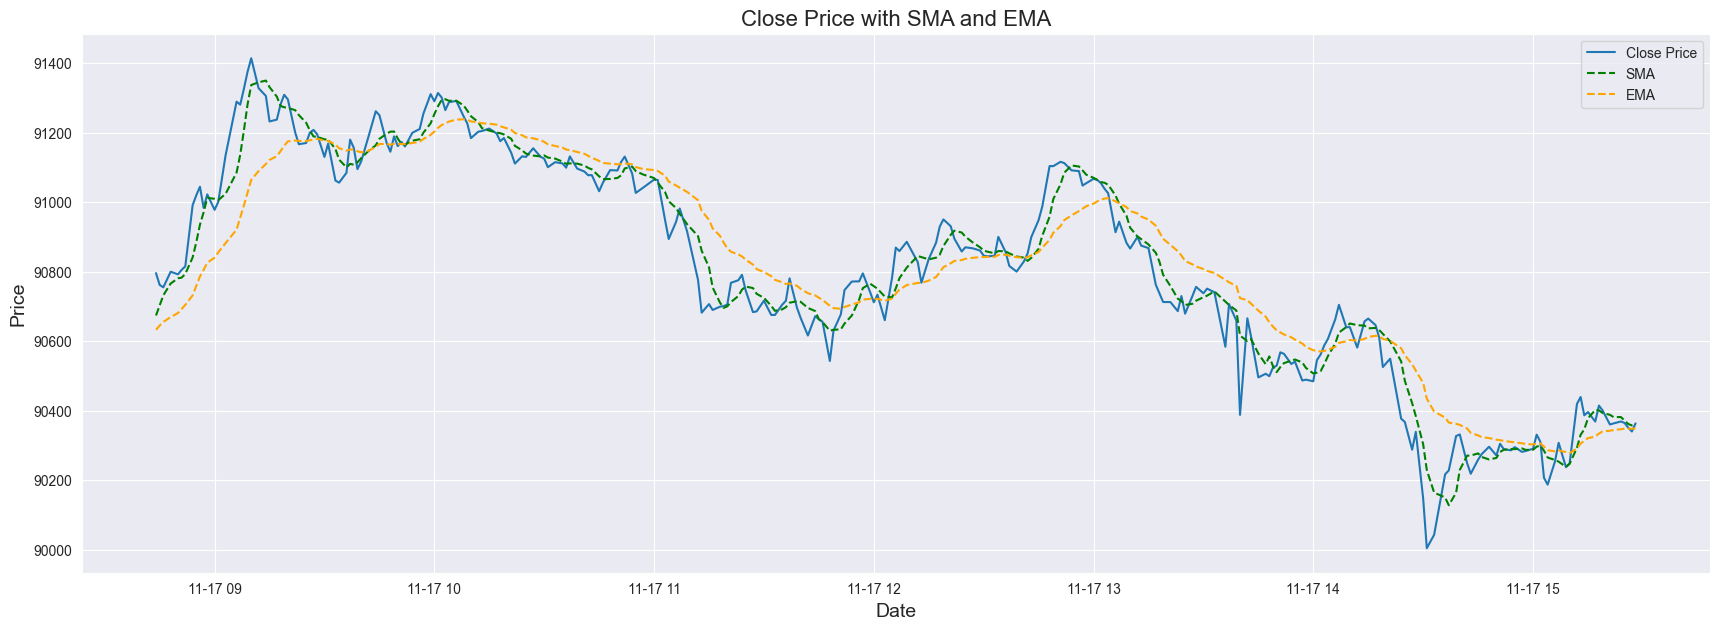

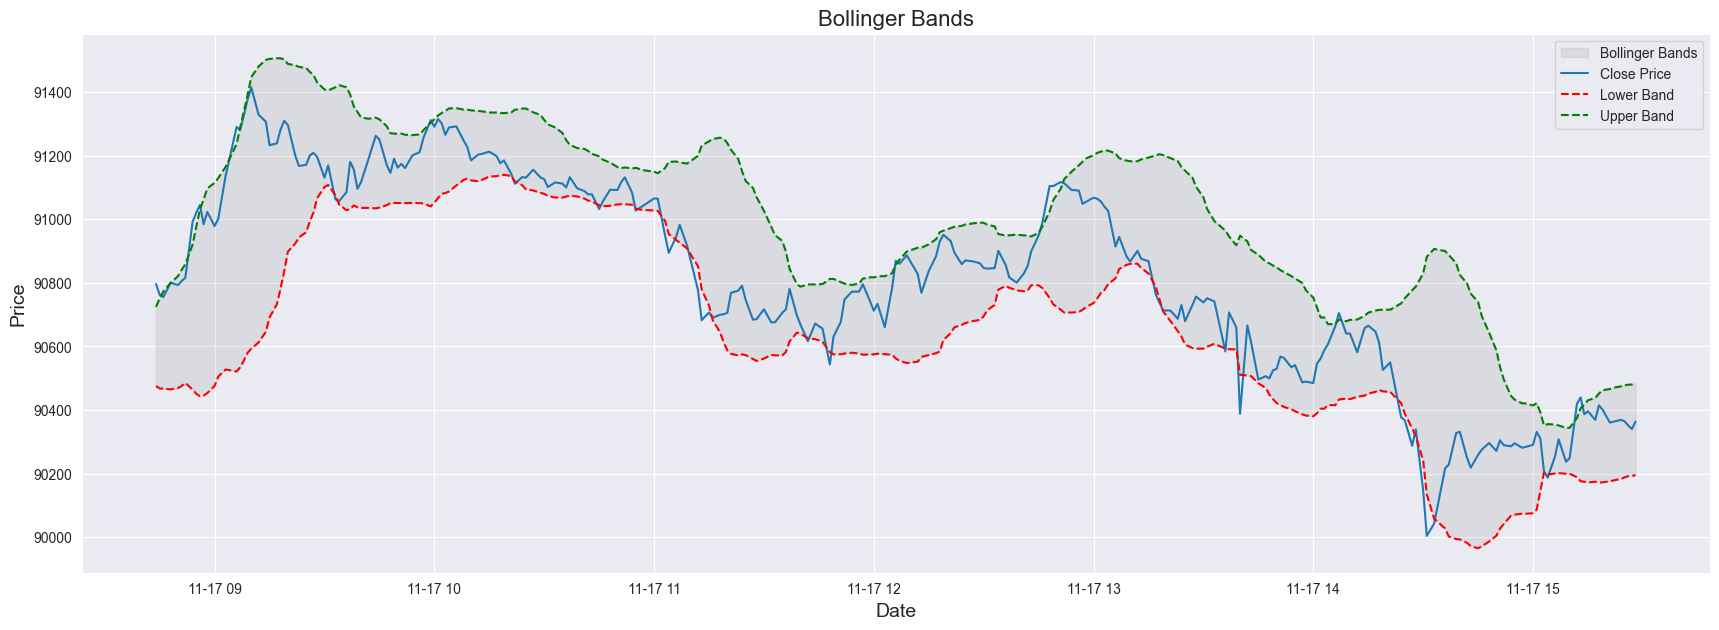

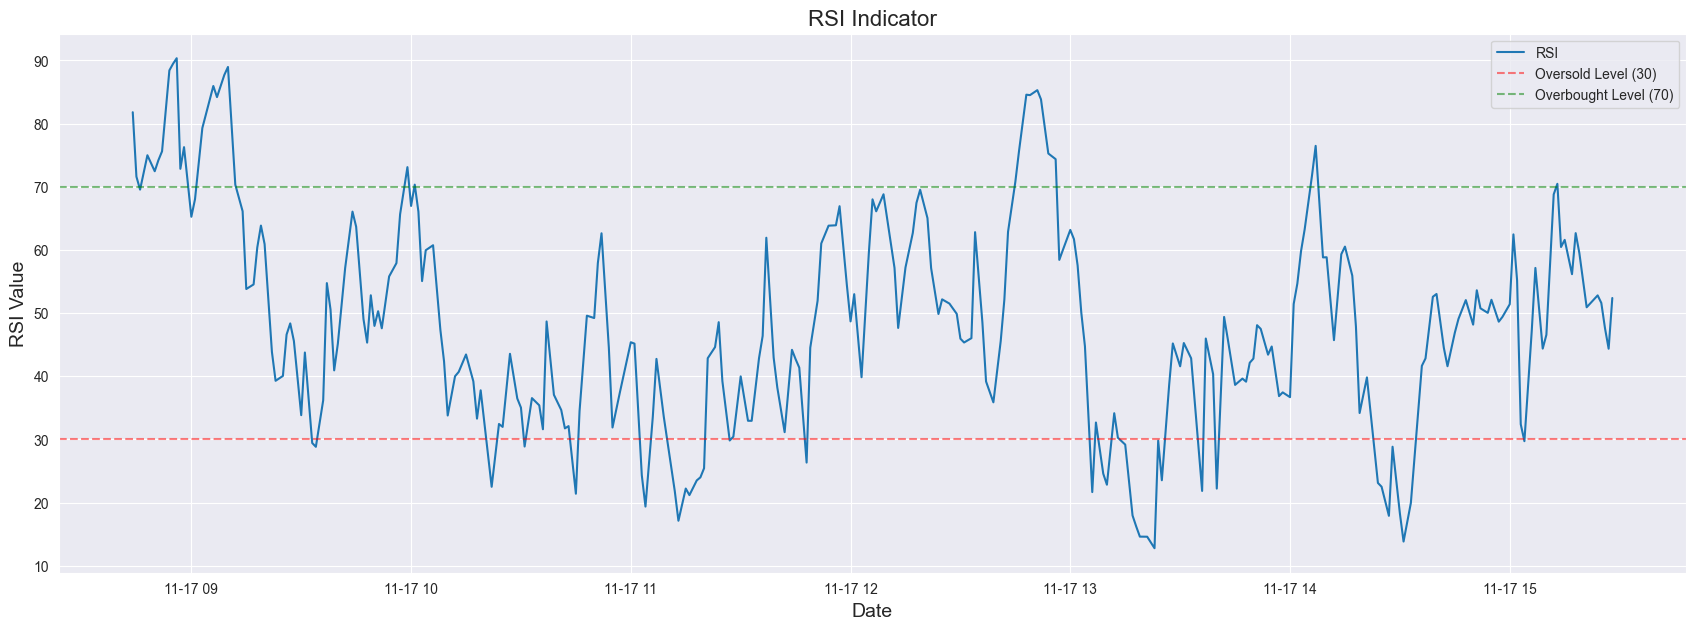

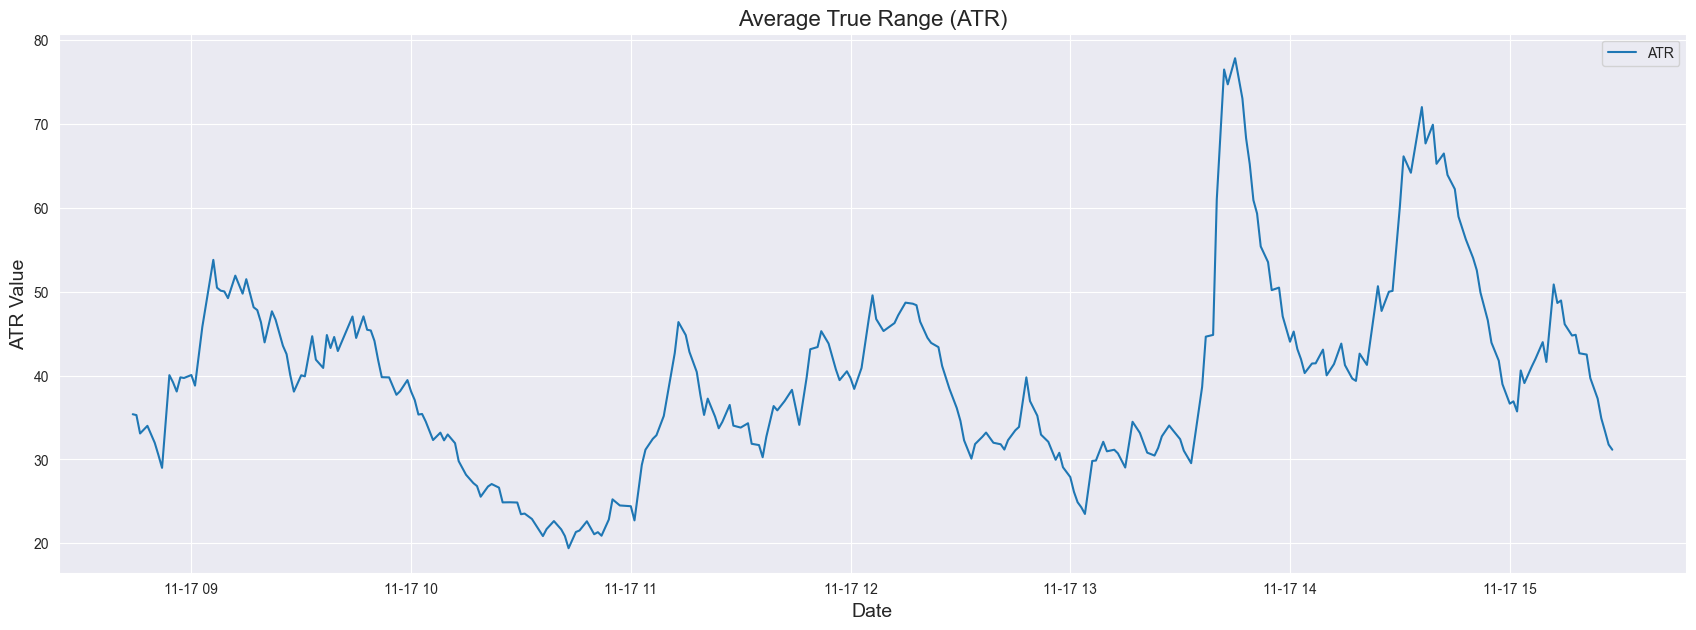

In [2]:
plot_ema_and_sma(processed_data)
plot_bollinger_bands(processed_data)
plot_rsi(processed_data)
plot_atr(processed_data)

In [3]:
data_with_signals = strategy.generate_buy_signals(processed_data)

Signals : [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, 0, 0, -1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, -1, -1, 0, 0, 0, 0, 0, -1, -1, -1, 0, 0, 0, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, 0, -1, -1, -1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, -1, -1, 0, 0, 0, 0, -1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, -1, -1, -1, -1, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0]


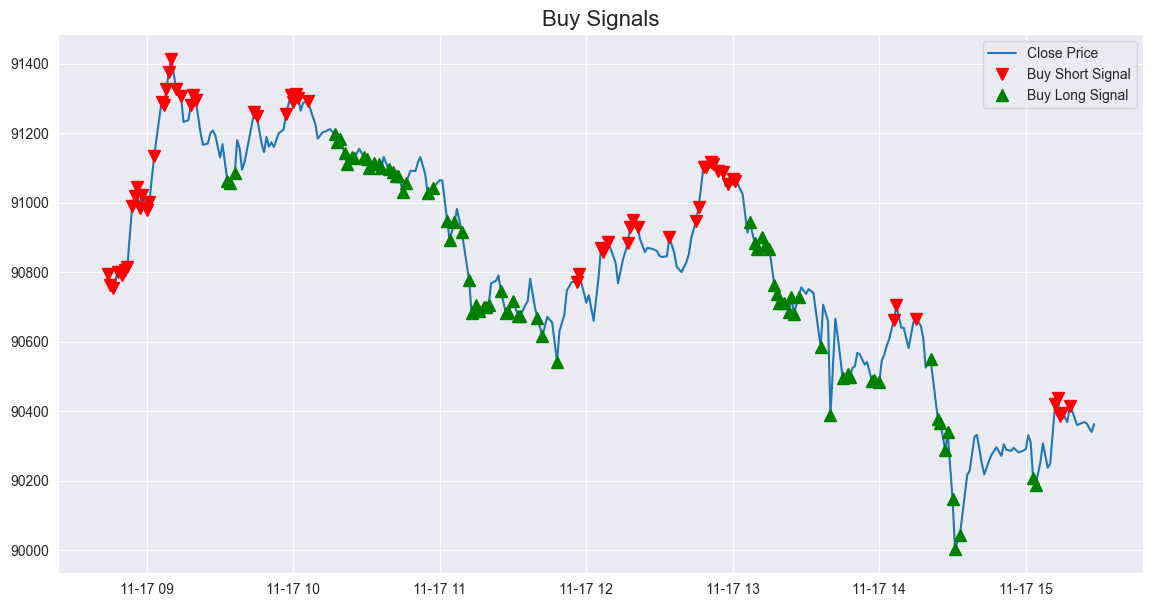

In [4]:
print("Signals :", data_with_signals["Signal"].tolist())
plot_signals(processed_data)

In [5]:
# transactions, equity_curve, dates = execute_trades(
#     data=data_with_signals,
#     initial_cash=initial_cash,
#     transaction_cost=transaction_cost,
#     leverage=leverage,
#     slippage_pct=slippage_pct,
#     risk_per_trade=risk_per_trade,
# )

from software.executor import TradingExecutor
from tqdm import tqdm

executor = TradingExecutor(
    initial_cash=initial_cash,
    transaction_cost=transaction_cost,
    leverage=leverage,
    slippage_pct=slippage_pct,
    risk_per_trade=risk_per_trade,
)

transactions = []
equity_curve = []
dates = []

print("Executor :", executor.__dict__)

Executor : {'cash': 3000, 'transaction_cost': 0.001, 'leverage': 1, 'slippage_pct': 0.0005, 'risk_per_trade': 0.02, 'positions': [], 'history': []}


In [ ]:
for index, row in tqdm(
    data_with_signals.iterrows(),
    total=len(data_with_signals),
    desc="Executing trades",
):
    signal = row["Signal"]
    price = row["Close"]
    date = index

    if len(executor.positions) == 0 and signal == 0:
        continue
    
    elif len(executor.positions) > 0 and signal == 0:
        executor.update_positions(price, date, stop_loss_price)
        continue

    elif len(executor.positions) == 0 and signal != 0:
        stop_loss_price = executor.calculate_stop_loss(price=price, row=row, signal=signal, risk_factor=0.02)
        executor.execute_signal(
            signal,
            price,
            stop_loss_price,
            date,
        )
        continue

    else:
        stop_loss_price = executor.calculate_stop_loss(price=price, row=row, signal=signal, risk_factor=0.02)
        executor.update_positions(price, date, stop_loss_price)

    if executor.history and (
        not transactions or executor.history[-1] != transactions[-1]
    ):
        print("Adding transaction to history...")
        last_transaction = executor.history[-1]
        transactions.append(last_transaction)

    total_value = executor.get_total_portfolio_value(price)
    equity_curve.append(total_value)
    dates.append(date)


    # CODE FONCTIONNEL MAIS QUELQUES POINTS A REVOIR :
    # - Le SL est bien calculer mais un moment le prix monte, puis monte encore (short) mais le SL n'est pas atteint.
    # Cependant, le prix redescend et le SL change de valeur alors qu'il ne devrait pas.

Executing trades: 100%|█| 277/277 [00:00<00:00, 

Updated stop loss for  short  position at  90796.1953125  and new stop loss at  92292.53762649247
Updated stop loss for  short  position at  90762.15625  and new stop loss at  92292.53762649247
Updated stop loss for  short  position at  90755.234375  and new stop loss at  92292.53762649247
Updated stop loss for  short  position at  90800.1875  and new stop loss at  92292.53762649247
Updated stop loss for  short  position at  90792.65625  and new stop loss at  92292.53762649247
Updated stop loss for  short  position at  90805.578125  and new stop loss at  92292.53762649247
Updated stop loss for  short  position at  90815.7265625  and new stop loss at  92292.53762649247
Updated stop loss for  short  position at  90991.5390625  and new stop loss at  92292.53762649247
Updated stop loss for  short  position at  91020.15625  and new stop loss at  92292.53762649247
Updated stop loss for  short  position at  91044.7109375  and new stop loss at  92292.53762649247
Updated stop loss for  short  p

In [7]:
print("Transactions :", transactions)
print("Equity curve :", equity_curve)
print("Dates :", dates)



Transactions : [{'action': 'open', 'position_type': 'short', 'price': 90750.79721484375, 'date': Timestamp('2024-11-17 08:44:00+0000', tz='UTC')}, {'action': 'close', 'position_type': 'short', 'price': 91016.812578125, 'date': Timestamp('2024-11-17 09:33:00+0000', tz='UTC'), 'pnl': -266.0153632812435}, {'action': 'open', 'position_type': 'long', 'price': 91102.04388281249, 'date': Timestamp('2024-11-17 09:34:00+0000', tz='UTC')}, {'action': 'close', 'position_type': 'long', 'price': 91307.60755078125, 'date': Timestamp('2024-11-17 09:44:00+0000', tz='UTC'), 'pnl': 205.56366796875955}, {'action': 'open', 'position_type': 'short', 'price': 91204.94502734375, 'date': Timestamp('2024-11-17 09:45:00+0000', tz='UTC')}, {'action': 'close', 'position_type': 'short', 'price': 91152.33072265626, 'date': Timestamp('2024-11-17 10:17:00+0000', tz='UTC'), 'pnl': 52.61430468749313}, {'action': 'open', 'position_type': 'long', 'price': 91221.36132421874, 'date': Timestamp('2024-11-17 10:18:00+0000', t

In [8]:
performance_metrics = evaluate_performance(
    transactions, equity_curve, initial_cash
)

final_portfolio_value = equity_curve[-1]
total_profit = final_portfolio_value - initial_cash
print(f"Total Profit: ${total_profit:.2f}")

Total Profit: $94554.71


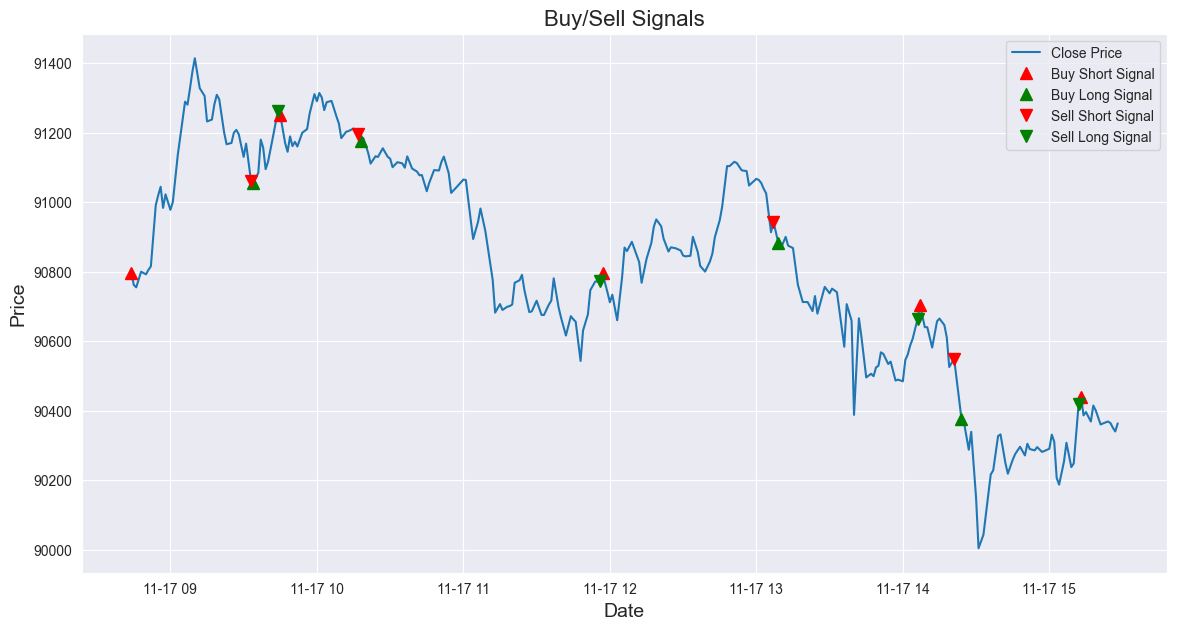

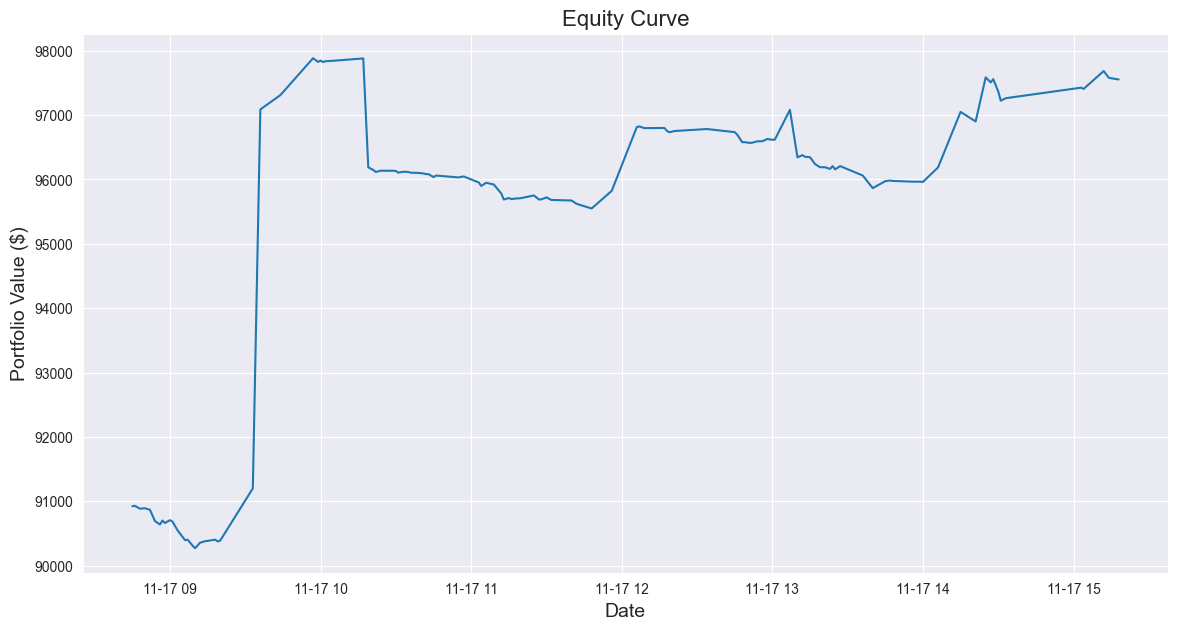

In [9]:
from software.plotter import plot_trades, plot_equity_curve

plot_trades(price_data=processed_data, transactions=transactions)
plot_equity_curve(dates, equity_curve)

- Add test and documentation to get a 100% coverage.
- Adjust the slippage.
- Add percentage of success trades.
- Add parameter to adjust the whole strategy.
- Add parameter to adjust the stop loss.
- Add indicator to adjust the strategy.
- Make every parameter adjustable in the strategy.
- Add model to adjust the strategy.
- List patterns of the close prices.
- Recognize the patterns with a classifier.
- Adapt the strategy to the patterns.
- Train each model with every pattern to get the best strategy.
- Match the best strategy with the current pattern.
- Add GPT api to adjust the risk by the news.